In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix

from scipy.stats import multivariate_normal as mvn
from sklearn.decomposition import PCA

## Helper Fuctions

In [2]:
def plot_gmm(model, data = None):
    x0 = np.linspace(-4, 4, 100)
    x1 = np.linspace(-4, 4, 100)
    x0_grid, x1_grid = np.meshgrid(x0, x1)
    x_test = np.array([x0_grid.ravel(), x1_grid.ravel()]).T
    y_pred = gm_model.score_samples(x_test)
    Z = -y_pred.reshape(x0_grid.shape)
    plt.contour(x0_grid, x1_grid, Z, levels=np.logspace(0, 3, 20), norm=LogNorm(vmin=1, vmax=100), alpha=0.8)
    if data is not None:
        plt.scatter(data[:,0],data[:,1],c='red')
    plt.scatter(gm_model.means_[:,0], gm_model.means_[:,1],c='black')

## Random Noise

(-4.0, 4.0)

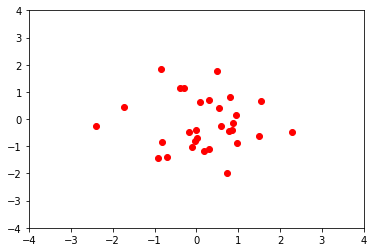

In [3]:
X = np.random.normal(size=(30,2))
plt.scatter(X[:,0],X[:,1],c='red')
plt.xlim(-4, 4)
plt.ylim(-4, 4)

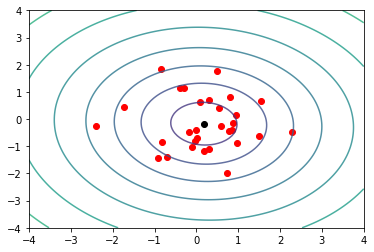

In [4]:
gm_model = GaussianMixture(1)
gm_model.fit(X)
plot_gmm(gm_model, X)

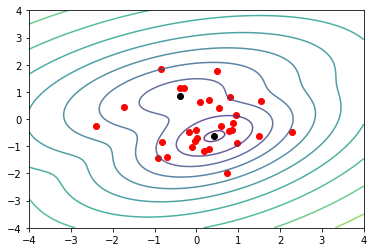

In [5]:
gm_model = GaussianMixture(2)
gm_model.fit(X)
plot_gmm(gm_model, X)

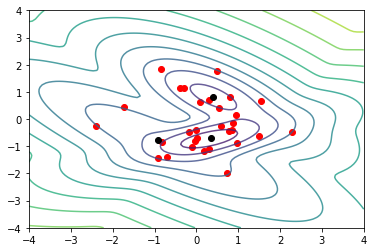

In [6]:
gm_model = GaussianMixture(3)
gm_model.fit(X)
plot_gmm(gm_model, X)

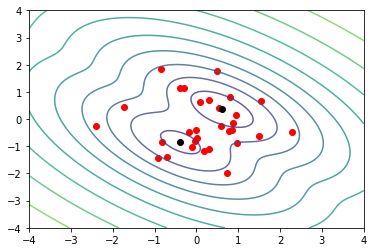

In [7]:
gm_model = GaussianMixture(2,covariance_type='tied')
gm_model.fit(X)
plot_gmm(gm_model, X)

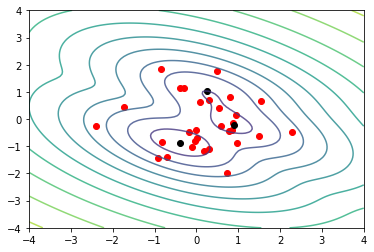

In [8]:
gm_model = GaussianMixture(3,covariance_type='tied')
gm_model.fit(X)
plot_gmm(gm_model, X)

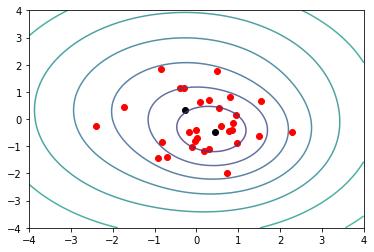

In [9]:
gm_model = GaussianMixture(2,covariance_type='spherical')
gm_model.fit(X)
plot_gmm(gm_model, X)

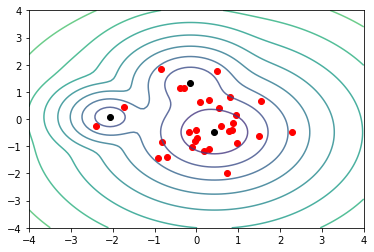

In [10]:
gm_model = GaussianMixture(3,covariance_type='spherical')
gm_model.fit(X)
plot_gmm(gm_model, X)

In [11]:
# How to calculated density per gaussian at specified points

poi = [[0,0], [0.34,0.58], [2,-1]]

dens = []
for hill, cov in zip(gm_model.means_, gm_model.covariances_):
    dens.append(mvn(hill, cov).pdf(poi))
np.array(dens)

array([[1.59327031e-02, 1.26726475e-01, 4.54861724e-10],
       [2.12179165e-08, 1.31514063e-11, 8.65078244e-33],
       [1.96127696e-01, 1.03030603e-01, 2.46861578e-02]])

## Preprocess

In [12]:
raw_df = pd.read_csv('Heart.csv',index_col=0)
raw_df.dropna(inplace=True)
df = pd.get_dummies(raw_df, columns=['ChestPain', 'Thal'])
names =[col for col in df.columns if col != 'AHD'] 
X = df[names]
y = np.where(df['AHD']=="Yes", 1, 0)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1337)
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
X_pos = X_train[y_train==1]
X_neg = X_train[y_train==0]
hills_pos = int(np.sqrt(len(X_pos)))
hills_neg = int(np.sqrt(len(X_neg)))
print(hills_pos, hills_neg)

9 10


In [15]:
gm_pos = GaussianMixture(n_components=hills_pos).fit(X_pos)
gm_neg = GaussianMixture(n_components=hills_neg).fit(X_neg)

In [16]:
pred_pos = gm_pos.score_samples(X_test)
pred_neg = gm_neg.score_samples(X_test)
y_pred = (pred_pos>pred_neg).astype(int)
print(accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

0.7676767676767676


array([[42,  7],
       [16, 34]])

In [17]:
y_pred_fixed = (pred_neg<-1e-5).astype(int)
print(accuracy_score(y_test, y_pred_fixed))
confusion_matrix(y_test, y_pred_fixed)

0.6464646464646465


array([[16, 33],
       [ 2, 48]])

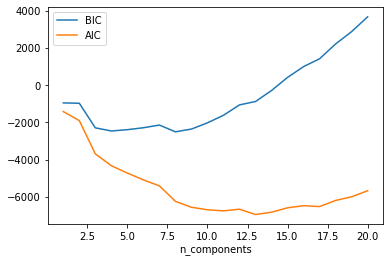

In [18]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n_components=n, random_state=1337).fit(X_pos)
          for n in n_components]

plt.plot(n_components, [m.bic(X_pos) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_pos) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

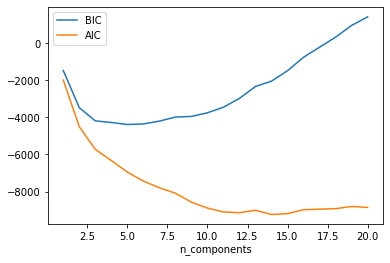

In [19]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n_components=n, random_state=1337).fit(X_neg)
          for n in n_components]

plt.plot(n_components, [m.bic(X_neg) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_neg) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

## Outliers

In [20]:
pred_train_pos = gm_pos.score_samples(X_train)
pred_train_neg = gm_neg.score_samples(X_train)
print(np.mean(pred_train_pos), np.mean(pred_train_neg))
print(np.std(pred_train_pos), np.std(pred_train_neg))

-209850.39134874436 -116158.13032670876
281434.59147913824 245917.00319014676


(array([  5.,   2.,   2.,  20.,  20.,   4.,   3.,  17.,   9., 116.]),
 array([-1.00004949e+06, -9.00035499e+05, -8.00021504e+05, -7.00007510e+05,
        -5.99993516e+05, -4.99979522e+05, -3.99965528e+05, -2.99951534e+05,
        -1.99937540e+05, -9.99235458e+04,  9.04482513e+01]),
 <a list of 10 Patch objects>)

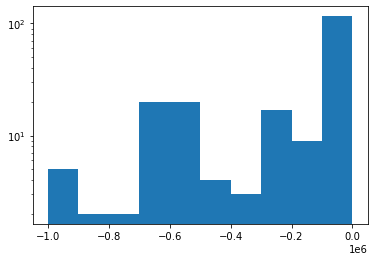

In [21]:
plt.hist(pred_train_pos, log=True)

(array([  1.,   6.,   0.,   1.,   5.,   9.,   1.,   8.,   7., 160.]),
 array([-1.23980996e+06, -1.11582106e+06, -9.91832156e+05, -8.67843255e+05,
        -7.43854354e+05, -6.19865454e+05, -4.95876553e+05, -3.71887652e+05,
        -2.47898751e+05, -1.23909851e+05,  7.90500143e+01]),
 <a list of 10 Patch objects>)

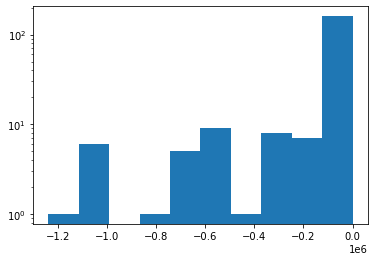

In [22]:
plt.hist(pred_train_neg, log=True)

In [23]:
np.logical_and(pred_train_pos<-6e-5, pred_train_neg<-6e-5)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

## Implemention of EM algorithm from scratch (code not confirmed)

In [24]:
# prep data
# data = np.array([[1,2,3,4,5,6],[1,3,5,7,9,9],[1,0,1,0,1,0],[1,0,1,0,1,0]]).T 
data = np.random.random((10,1000))
normed = data - data.mean(axis=0,keepdims=True)
npc=3
m=data.shape[0] # number of data samples

pca = PCA(npc)
data_rd = pca.fit_transform(normed)
data_rd = data_rd.T # to match code below


In [25]:
# initialzation
k = 2  # number of mixture components
mu_old = np.random.randn(k, npc)
mu_new = mu_old + 10

sigma_old = np.empty((k, npc, npc))
for ii in range(k):
    tmp = np.random.randn(npc, npc)
    tmp = tmp@tmp.T +1
    sigma_old[ii] = tmp
sigma_new = sigma_old + 10

pi_old = np.ones(k)/k # uniform guess
pi_new = np.zeros(2)

tau = np.zeros((m,k), dtype=float)

In [26]:
# mvn(mu, sigma).pdf(point) returns the denisty at that point for the gaussian defined by that mu, sigma
print(mvn(mu_old[0], sigma_old[0]).pdf([0,0,0])) # at some random point
print(mvn(mu_old[0], sigma_old[0]).pdf(mu_old[0])) # at the center of the gaussian

0.002022777877246523
0.01581310321704287


Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8


<ipython-input-27-d740cc2bf8b1>:29: RuntimeWarning: divide by zero encountered in log
  loglikelihood += np.log(pi_new[i] * mvn(mu_new[i], sigma_new[i], allow_singular=True).pdf(data_rd.T))


Text(0.5, 0, 'iteration')

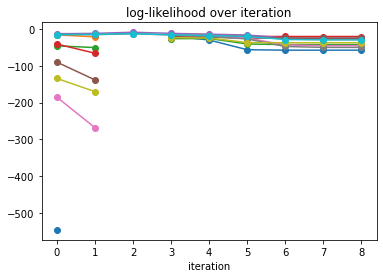

In [27]:
ll_all = []
maxIter = 100
tol = 1e-2

for iteration in range(maxIter):
    print('Iteration: ', iteration)
    
    ## E-step    
    for i in range(k):
        tau[:,i] = pi_old[i] * mvn(mu_old[i], sigma_old[i], allow_singular=True).pdf(data_rd.T)
    tau = tau / tau.sum(axis=1, keepdims=True)
    
    ## M-step
    # update mu
    mu_new = tau.T @ data_rd.T
    mu_new = mu_new / tau.sum(axis=0).reshape(-1,1)
    
    # update sigma
    for i in range(k):
        tmp = data_rd.T - mu_new[i]
        sigma_new[i] = tmp.T @ np.diag(tau[:,i]) @tmp / tau[:,i].sum()
    
    # update pi
    pi_new = tau.sum(axis=0)/tau.sum()

    # check log-likelihood
    loglikelihood = 0  # likelihood
    for i in range(k):
        loglikelihood += np.log(pi_new[i] * mvn(mu_new[i], sigma_new[i], allow_singular=True).pdf(data_rd.T))
    ll_all.append(loglikelihood)
    
    if np.linalg.norm(mu_new.ravel() - mu_old.ravel()) < tol:
        break
        
    mu_old = mu_new
    sigma_old = sigma_new
    pi_old = pi_new
    
    
plt.plot(ll_all,'-o')
plt.title('log-likelihood over iteration')
plt.xlabel('iteration')
